In [1]:
# Load libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn import linear_model
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg


# Explore data

In [2]:
# Read data
# This analysis is based on
# https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
data = pd.read_csv('../raw_data/German_stock_prices_sample.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TICKER       999 non-null    object 
 1   FIGI         999 non-null    object 
 2   DATE         999 non-null    object 
 3   TYPE         999 non-null    object 
 4   FREQUENCY    999 non-null    object 
 5   OPEN         999 non-null    float64
 6   HIGH         999 non-null    float64
 7   LOW          999 non-null    float64
 8   CLOSE        999 non-null    float64
 9   VOLUME       999 non-null    float64
 10  ADJ_OPEN     999 non-null    float64
 11  ADJ_HIGH     999 non-null    float64
 12  ADJ_LOW      999 non-null    float64
 13  ADJ_CLOSE    999 non-null    float64
 14  ADJ_VOLUME   999 non-null    float64
 15  ADJ_FACTOR   7 non-null      float64
 16  EX_DIVIDEND  999 non-null    float64
 17  SPLIT_RATIO  999 non-null    float64
dtypes: float64(13), object(5)
memory usage: 140.6+ KB


In [3]:
# Explore content
data.head()

,TICKER,FIGI,DATE,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
0,GEF,BBG000BLFQH8,2013-01-04,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
1,GEF,BBG000BLFQH8,2013-01-03,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2,GEF,BBG000BLFQH8,2013-01-02,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
3,GF,BBG000C3C6S2,2018-06-05,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
4,GF,BBG000C3C6S2,2018-06-04,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


### Look for missing values

In [4]:
data['DATE'].isna().value_counts()

False    999
Name: DATE, dtype: int64

In [5]:
data['CLOSE'].isna().value_counts()

False    999
Name: CLOSE, dtype: int64

Fine, there is no missing values for the columns I will use


In [6]:
# We want to know the sampling interval
print(sorted(data['DATE'])[:5])
print(sorted(data['DATE'])[-5:])

['2013-01-02', '2013-01-03', '2013-01-04', '2014-06-23', '2014-06-24']
['2018-05-30', '2018-05-31', '2018-06-01', '2018-06-04', '2018-06-05']


The sampling interval is quasi daily; but some days are missing. We have to take this into account in the following steps

## Prepare data

## Transform data column into datetime type and use it as index

In [7]:
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.sort_values(by=['DATE'])
data.set_index('DATE', inplace=True)

### Drop unnecessary entries and columns

In [8]:
# Drop entries that are not from the German Fund 
# and also those that are not of the end of the day
data = data[data.TICKER == 'GF']
data = data[data.TYPE == 'EOD']
data['TICKER'].count()

995

In [9]:
data

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2014-06-23,GF,BBG000C3C6S2,EOD,daily,19.05,19.0500,18.9500,18.9500,34300.0,11.981724,11.981724,11.918828,11.918828,34300.0,NaN,0.0,1.0
2014-06-24,GF,BBG000C3C6S2,EOD,daily,18.91,18.9500,18.8300,18.8300,35200.0,11.893669,11.918828,11.843352,11.843352,35200.0,NaN,0.0,1.0
2014-06-25,GF,BBG000C3C6S2,EOD,daily,18.66,18.7200,18.5900,18.6000,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0
2014-06-26,GF,BBG000C3C6S2,EOD,daily,18.52,18.5901,18.4200,18.5300,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0
2014-06-27,GF,BBG000C3C6S2,EOD,daily,18.63,18.6300,18.5100,18.6100,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,NaN,0.0,1.0
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0


We only dropped a few entries (4 = 999 - 995)

In [10]:
# Only keep columns of interest 
data.drop(data.columns.difference(['CLOSE']), 1, inplace=True)

### Visualize the data

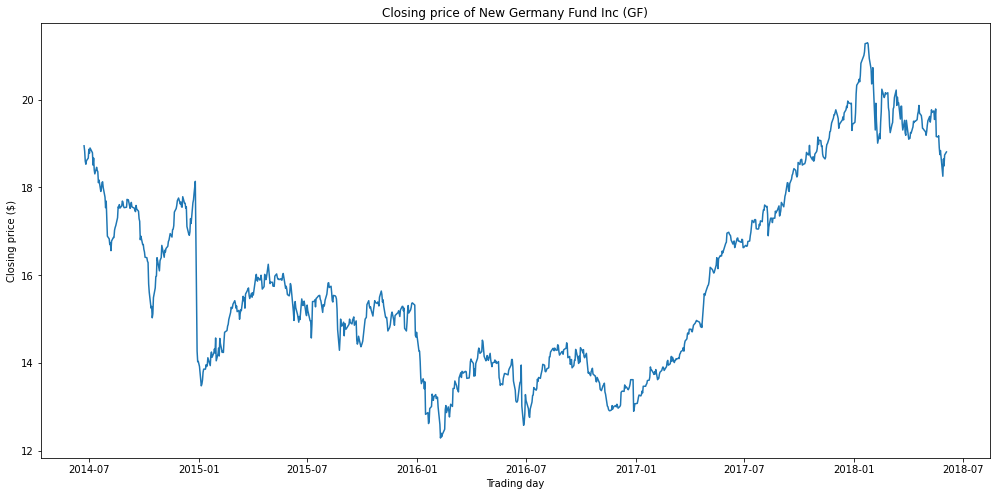

In [11]:
plt.figure(figsize=(17, 8))
plt.plot(data['CLOSE'])
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.show()

## Moving average smoothing

In [12]:
# Let's see what happens if we use a rolling window
## The window is the number of observations used for calculating the statistic. 
## Each window will be a fixed size.
data['moving_average_3d'] = data.rolling(window=3).mean()['CLOSE']
data['moving_average_7d'] = data.rolling(window=7).mean()['CLOSE']
data['moving_average_30d'] = data.rolling(window=30).mean()['CLOSE']

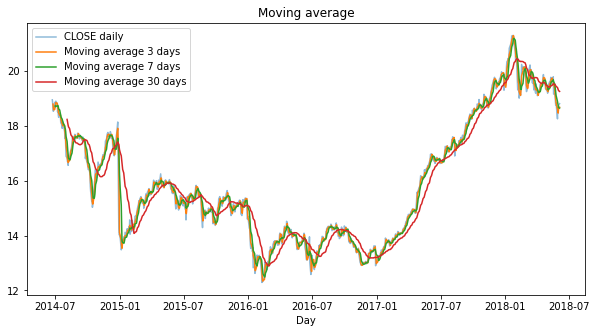

In [14]:
# Visualize smoothed data
f = plt.figure(figsize=(10, 5))
plt.plot(data['CLOSE'], label ='Closing price', alpha=0.5)
plt.plot(data['moving_average_3d'])
plt.plot(data['moving_average_7d'])
plt.plot(data['moving_average_30d'])
plt.xlabel('Day')
plt.legend(['CLOSE daily', 'Moving average 3 days', 'Moving average 7 days', 'Moving average 30 days'])
plt.title('Moving average')
plt.show()

A window of 7 or 30 days captures the behavior of the data

## Autocorrelation plot

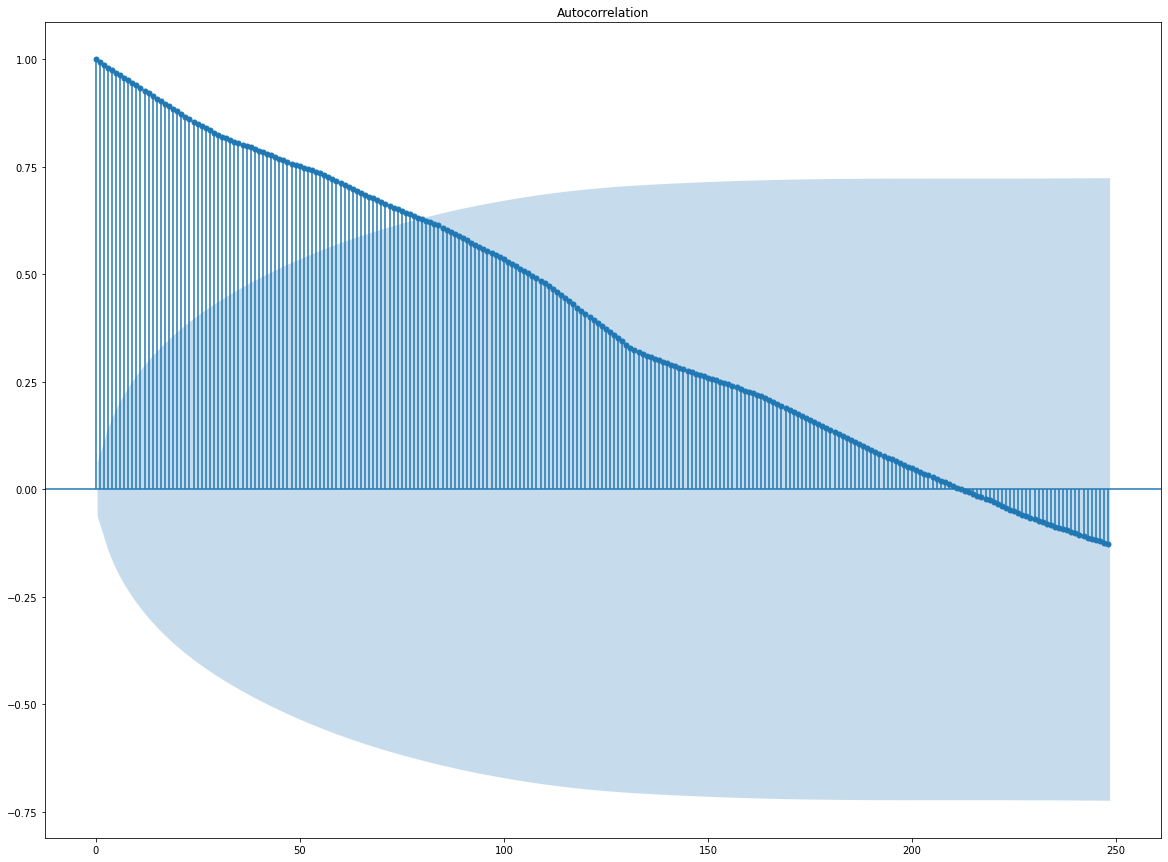

In [55]:
# Plot of a quarter of the raw data
f=plt.figure(figsize=(20, 15))
ax = plt.subplot(111)
sm.graphics.tsa.plot_acf(data['CLOSE'], ax, lags=len(data)/4)
plt.show()

**WARNING** The data is not stationary. The analysis will proceed only for illustrative purposes; but for a real analysis we must transform the data to make it stationary or decompose it into the seasonal and the trend components

## Drop unnecessary columns for the analysis

In [56]:
data.columns

Index(['CLOSE', 'moving_average_3d', 'moving_average_7d',
       'moving_average_30d'],
      dtype='object')

In [57]:
data.drop(data.columns.difference(['CLOSE']), axis=1, inplace=True)
data = data.asfreq('D')

In [58]:
data.head()

,CLOSE
DATE,
2014-06-23,18.95
2014-06-24,18.83
2014-06-25,18.60
2014-06-26,18.53
2014-06-27,18.61


In [59]:
data.index

DatetimeIndex(['2014-06-23', '2014-06-24', '2014-06-25', '2014-06-26',
               '2014-06-27', '2014-06-28', '2014-06-29', '2014-06-30',
               '2014-07-01', '2014-07-02',
               ...
               '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29',
               '2018-05-30', '2018-05-31', '2018-06-01', '2018-06-02',
               '2018-06-03', '2018-06-04'],
              dtype='datetime64[ns]', name='DATE', length=1443, freq='D')

# Split data into training and test sets

In [60]:
# Split dataset into training and testing subsets
# Use 3/4 of the data for training and the rest for testing
split_index = round(len(data)*3/4)

In [61]:
train_data = data.iloc[:split_index,:]
test_data = data.iloc[split_index:,:]
len(train_data), len(test_data)

(1082, 361)

### Fill missing values with the previous observation

The NA filling is done by separate to avoid data leakage

In [62]:
train_data = train_data.fillna(method='ffill')
len(train_data)

1082

In [63]:
test_data = test_data.fillna(method='ffill')
len(test_data)

361

## Correlation at lag k

In [64]:
# Prepare X and y vectors
X = np.array(train_data.iloc[:len(train_data)-1])
y = np.array(train_data.iloc[1:len(train_data)])
len(X), len(y)

(1081, 1081)

In [65]:
# Fit model
lr = linear_model.LinearRegression()
lr.fit(X.reshape(len(X), 1), y)

LinearRegression()

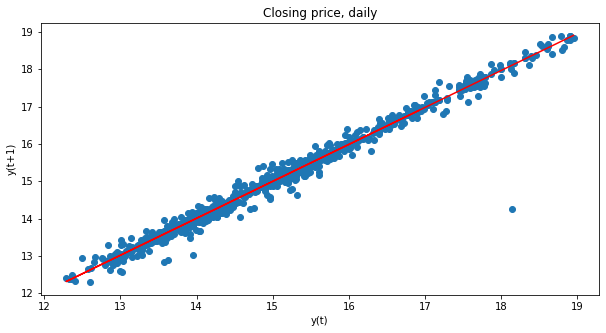

In [66]:
# Plot data
plt.figure(figsize=(10, 5))
plt.scatter(X, y)
plt.plot(X, lr.coef_*X + lr.intercept_, color='red') 
plt.xlabel('y(t)')
plt.ylabel('y(t+1)')
plt.title('Closing price, daily')
plt.show()

In [67]:
x_test = np.array(test_data.iloc[:len(test_data)-1])
y_test = np.array(test_data.iloc[1:len(test_data)])
y_pred = lr.predict(x_test)
r2_score(y_test, y_pred)

0.9822297670419868

The data is apparently lineally correlated with itself. Thus, we will use an autoregressive model as a starting point

## Train an autoregressive model. Lags = 1 (daily)

In [75]:
#train the autoregressive model
model = AutoReg(train_data['CLOSE'], lags=[1], trend='n')
model = model.fit()
predictions = model.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

In [76]:
print(f'AIC: {model.aic}')

AIC: -3.453337845902744


In [77]:
r2_score(test_data['CLOSE'], predictions)

-5.347923563397242

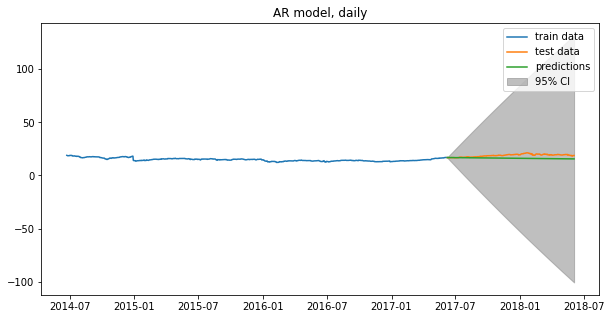

In [79]:
f = plt.figure(figsize=(10, 5))
plt.plot(train_data)
plt.plot(test_data)
model.plot_predict(start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    fig= f)
#plt.ylim(top = max_value)
plt.legend(['train data','test data', 'predictions', '95% CI'])
plt.title('AR model, daily')
plt.show()

## Train an autoregressive model. Lags = 7 (weekly)

In [88]:
#train the autoregressive model
model = AutoReg(train_data['CLOSE'], lags=[7], trend='n')
model = model.fit()
predictions = model.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

In [89]:
print(f'AIC: {model.aic}')
r2_score(test_data['CLOSE'], predictions)

AIC: -1.4748318174285764


-4.947885267180025

/home/mcastro/python_environments/dataScience/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:2021: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


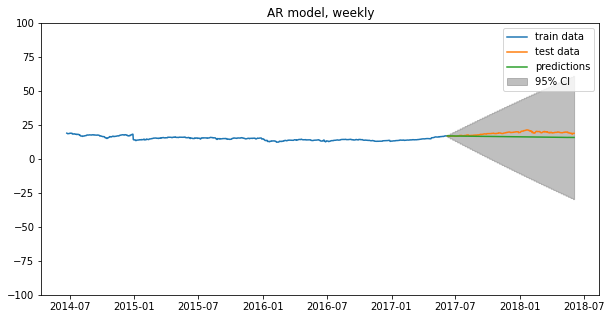

In [90]:
f = plt.figure(figsize=(10, 5))
plt.plot(train_data)
plt.plot(test_data)
model.plot_predict(start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    fig= f)
plt.ylim(top = 100, bottom=-100)
plt.legend(['train data','test data', 'predictions', '95% CI'])
plt.title('AR model, weekly')
plt.show()

## Train an autoregressive model. Lags = 30 (monthly)

In [84]:
#train the autoregressive model
model = AutoReg(train_data['CLOSE'], lags=[30], trend='n')
model = model.fit()
predictions = model.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

In [85]:
print(f'AIC: {model.aic}')
r2_score(test_data['CLOSE'], predictions)

AIC: -0.05811760051452753


-7.074735536553776

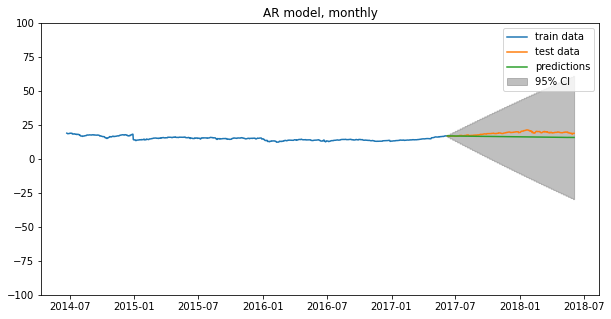

In [91]:
f = plt.figure(figsize=(10, 5))
plt.plot(train_data)
plt.plot(test_data)
model.plot_predict(start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    fig= f)
plt.ylim(top = 100, bottom= -100)
plt.legend(['train data','test data', 'predictions', '95% CI'])
plt.title('AR model, monthly')
plt.show()

The AIC of the monthly model is the lowest; thus, we go on with this model and discard the others

## Forecast for the following year with the AR monthly model

In [92]:
data['CLOSE'] = data['CLOSE'].fillna(method='ffill')
model = AutoReg(data['CLOSE'], lags=[30], trend='n')
model = model.fit()
predictions = model.predict(
    start=len(data)-1, 
    end=len(data)+(30*12), 
    dynamic=False)

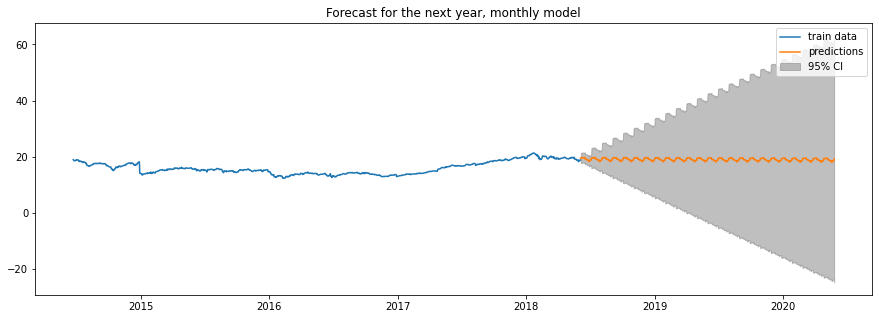

In [95]:
f = plt.figure(figsize=(15, 5))
plt.plot(data['CLOSE'], label='train data')
model.plot_predict(start=len(data)-1, 
                   end=len(data)+720, fig= f)
plt.legend(['train data','predictions', '95% CI'])
#plt.ylim(top = max_gmv)
plt.title('Forecast for the next year, monthly model')
plt.show()

We could improve our model adding extra information. We would include it as an exogenous variable in the model with the parameter "exog=train_data['col_title']"